This notebook is based on the ```single_static_target``` example. It is extended to include multiple Doppler bins (slow_time samples/chirps), which allows to estimate targets' relative Doppler and consequently targets' relative radial velocity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c0
import skradar
from scipy import signal
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Scene Setup
See the ```single_static_target``` example for a detailed description of the configuration of radar, target, and scene. Here we increase the number of chirps for Doppler processing.

Text(0.5, 0, 'z (m)')

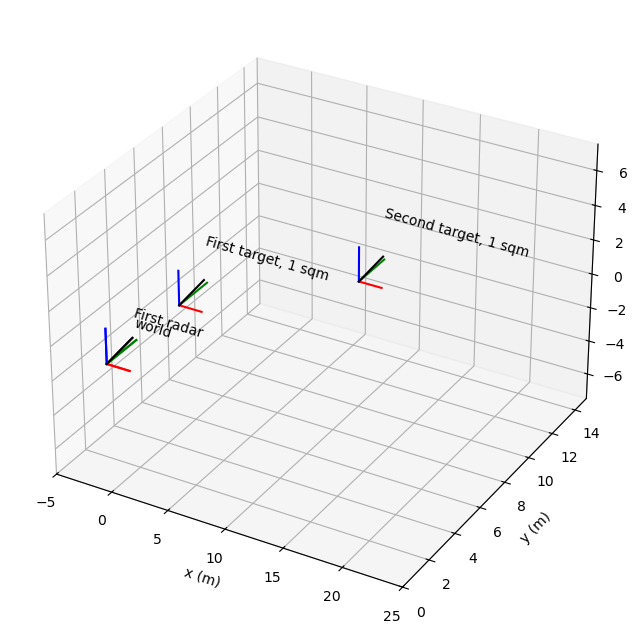

In [2]:
B = 1e9
fc = 76.5e9
N_f = 512  # number of fast-time samples
fs_f = 1e6  # fast-time sampling rate
Ts_s = (N_f - 1) / fs_f  # slow-time sampling interval
N_s = 32  # number of slow-time samples

lambd = c0 / fc

tx_pos = np.array([[0], [0], [0]])
N_rx = 8
rx_pos = np.zeros((3, N_rx))
# half-wavelength receive array along x
rx_pos[0, :] = np.arange(N_rx) * lambd / 2
radar_pos = np.array([[0], [0], [0]])
radar = skradar.FMCWRadar(B=B, fc=fc, N_f=N_f, T_f=1 / fs_f, T_s=Ts_s,
                          N_s=N_s, tx_pos=tx_pos, rx_pos=rx_pos,
                          pos=radar_pos, name='First radar')

v_max = lambd / (4 * Ts_s)  # Maximum unambiguous velocity
radar_vel = v_max / 2  # m/s
radar.vel = np.array([[0], [radar_vel], [0]])  # moving only in the y-direction

target_lst = list()
target_lst.append(skradar.Target(rcs=1, pos=np.array(
    [[0], [5], [0]]), name='First target, 1 sqm'))
target_lst.append(skradar.Target(rcs=1, pos=np.array(
    [[10], [10], [0]]), name='Second target, 1 sqm'))

scene = skradar.Scene([radar], target_lst)

fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((-5, 25))
ax.set_ylim((0, 15))
ax.set_zlim((-7.5, 7.5))
scene.visualize('world', ax, coord_len=2)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

# Radar Signal Simulation and Range Processing
Simulate chirps and perform range-compression

In [3]:
radar.sim_chirps()
radar.range_compression(zp_fact=4)

# Doppler Processing
Calculate relative Doppler using the range profile data.

In [4]:
radar.doppler_processing(zp_fact=4)
# actually move to the new position for the next time step
scene.update_poses(Ts_s * N_s)

Now we shall be able to see the range-Doppler plot. We expect the targets to have a non-zero radial velocity relative to the radar. 

Because we only translated in the y-direction moving closer to targets, the target with its position x aligned to radar's x-position ("First Target") shall have relative radial velocity **equal** to $radar_{vel}$. 

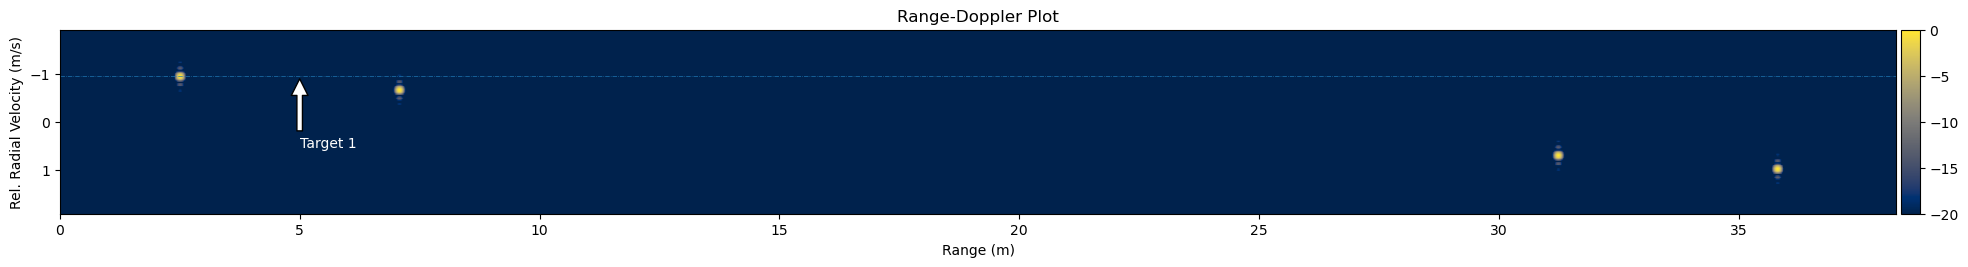

In [5]:
fig, ax = plt.subplots(1, figsize=(24, 20))
rx_idx = 0
tx_idx = 0
# Convert Doppler image to dB
dp_plot = 20 * \
    np.log10(np.abs(np.fft.fftshift(radar.rd[tx_idx, rx_idx, :, :], axes=0)))
dp_plot -= np.max(dp_plot)  # Normalize
plotlevel = -20
dp_plot[dp_plot < plotlevel] = plotlevel
im = ax.imshow(dp_plot, extent=[
               0, radar.ranges[-1] / 4, v_max, -v_max], cmap="cividis")
# Line at radar's radial velocity * -1
ax.axhline(y=-(np.sqrt(radar.vel[0]**2 + radar.vel[1]**2)), ls="-.", lw=.5)
ax.annotate('Target 1', color="white", xy=(target_lst[0].pos[1], -radar_vel),
            xytext=(target_lst[0].pos[1], -radar_vel + 1.5),
            arrowprops=dict(facecolor='white', shrink=0.05))
ax.set_xlabel("Range (m)")
ax.set_ylabel("Rel. Radial Velocity (m/s)")
ax.set_title(f"Range-Doppler Plot")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='1%', pad=0.05)
fig.colorbar(im,ax=ax,cax=cax);